In [17]:

import torch
from tqdm import tqdm
import torch.nn.functional as F
import wandb
import numpy as np
import torch.nn as nn
import math
import matplotlib.pyplot as plt

from eot_benchmark.gaussian_mixture_benchmark import get_test_input_samples
from eot_benchmark.metrics import compute_BW_UVP_by_gt_samples

from notebooks_utils import (get_indepedent_plan_sample_fn, get_discrete_ot_plan_sample_fn,
                   get_gt_plan_sample_fn_EOT, EOTGMMSampler) 

from notebooks_utils import pca_plot
from notebooks_utils import SwissRollSampler, StandardNormalSampler, pca_plot

torch.set_default_tensor_type(torch.DoubleTensor)


## Parameters

In [18]:

dim = 2
eps = 0.1
device = 'cuda:0'

drift_estimation_method = 'MC'

sample_sde_em_steps = 1000

# MC method parameters
n_mc_samples = 1000

# MCMC method parameters
n_prime_samples = 100
n_double_prime_samples = 10
eta = 0.0001
n_steps = 50
sampling_eta = 0.0001


In [19]:

import torch
import torch.nn as nn
import math

def langevin_sample(x_0, score_fn, eta=0.05, n_steps=10):
    for i in range(n_steps):
        noise = torch.randn_like(x_0)
        x_0 = x_0 + eta / 2 * score_fn(x_0).detach() + math.sqrt(eta) * noise
        
    return x_0

class HardSBM(nn.Module):
    def __init__(self, dim, sch_net, eps):
        super().__init__()  
        self.dim = dim
        self.sch_net = sch_net
        self.eps = eps

    def get_grad_log_potential(self, x):
        
        with torch.enable_grad():
            x_clone = x.clone().detach()
            x_clone.requires_grad = True
            log_potential = self.sch_net(x_clone)
            grad_log_potential = torch.autograd.grad(
                outputs=log_potential, 
                inputs=x_clone,
                grad_outputs=torch.ones_like(log_potential),
                create_graph=True,
                retain_graph=True,
            )[0]
        
        return grad_log_potential
    
    @torch.no_grad()
    def sample_p_t_drift(self, x_t, t, x_proposal=None, eta=0.005, n_steps=100):
        # sample via Langevin dynamics
        
        if x_proposal is None:
            x_proposal = x_t.clone().detach()
        
        def score_fn_val(x):
            return -(x - x_t) / (self.eps * (1 - t)) + self.get_grad_log_potential(x)
        
        score_fn = score_fn_val
        
        return langevin_sample(x_proposal, score_fn, eta=eta, n_steps=n_steps)
    
    def get_drift_MC(self, x_t, t, n_prime_samples=20):

        device = next(iter(self.sch_net.parameters())).device
        with torch.enable_grad():
            noise = torch.randn([n_prime_samples, x_t.shape[0], x_t.shape[1]]).to(device)
            
            x = torch.clone(x_t)
            x = torch.tensor(x, requires_grad=True)
            
            x = x.unsqueeze(0).repeat([n_prime_samples, 1, 1])
            t = t.unsqueeze(0).repeat([n_prime_samples, 1, 1])
            
            phi_val = torch.exp(self.sch_net((x + torch.sqrt((1 - t) * self.eps) * noise)))
            
            grad_phi = torch.autograd.grad(phi_val, x, grad_outputs=torch.ones_like(phi_val, device=phi_val.device), create_graph=True)[0]
            
        return self.eps * grad_phi.mean(0) / (phi_val).mean(0)

    def get_drift_MCMC(self, x_t, t, n_prime_samples=25, n_double_prime_samples=10,
                            eta=1e-4, n_steps=100, reinforce=False):
                
        x_t_prime = x_t.unsqueeze(1).repeat([1, n_prime_samples, 1]).reshape([-1, self.dim])
        t_prime = t.unsqueeze(1).repeat([1, n_prime_samples, 1]).reshape([-1, 1])
                    
        x_prime_samples_p_t = self.sample_p_t_drift(x_t_prime, t_prime, eta=eta, n_steps=n_steps)
        
        x_prime_samples_p_t = x_prime_samples_p_t.reshape([-1, n_prime_samples, self.dim])
                
        drift = 1 / (1 - t) * (x_prime_samples_p_t.mean(dim=1) - x_t)
        
        if reinforce:
            # return g(x_t, t) ready for autograd differentiation via Reinforce
            
            x_t_double_prime = x_t.unsqueeze(1).unsqueeze(1).repeat([1, n_prime_samples, n_double_prime_samples, 1]).reshape([-1, self.dim])
            t_double_prime = t.unsqueeze(1).unsqueeze(1).repeat([1, n_prime_samples, n_double_prime_samples, 1]).reshape([-1, 1])
            
            x_double_prime_samples_p_t = self.sample_p_t_drift(x_t_double_prime, t_double_prime, eta=eta, n_steps=n_steps)
            x_double_prime_samples_p_t = x_double_prime_samples_p_t.reshape([-1, n_prime_samples, n_double_prime_samples, self.dim])
            
            drift_reinforce = 1 / (1 - t) * (x_prime_samples_p_t * (self.sch_net(x_prime_samples_p_t) - self.sch_net(x_double_prime_samples_p_t).mean(dim=2))).mean(dim=1)
            
            return drift, drift_reinforce
        
        return drift
   
    def get_drift(self, x_t, t, n_prime_samples=25, n_double_prime_samples=10,
                  eta=1e-4, n_steps=100, reinforce=False):
        return self.get_drift_MCMC(x_t, t, n_prime_samples=25, n_double_prime_samples=10,
                                        eta=1e-4, n_steps=100, reinforce=False)
        
    def __call__(self, x_0):
        return self.sample(x_0)

    @torch.no_grad()
    def sample(self, x_0, mode='langevin'):
        raise NotImplementedError('Basic sample is not decided yet')

    @torch.no_grad()
    def sample_sde(self, x_0, em_steps=100, n_prime_samples=100, eta=1e-4, n_steps=100):
        t = torch.zeros(x_0.shape[0], device=x_0.device) + 1e-3
        dt = 1. / em_steps

        x_t = x_0
        with torch.no_grad():
            for i in range(em_steps - 1):
                drift = self.get_drift(x_t, t.unsqueeze(-1), n_prime_samples=n_prime_samples,
                                                eta=eta, n_steps=n_steps)

                x_t = x_t + drift*dt + math.sqrt(dt)*math.sqrt(self.eps)*torch.randn_like(x_t, device=x_t.device)
                t += dt

        return x_t
    
    def get_log_prob_fn(self, x_0):
        
        return lambda x: -torch.norm(x - x_0, dim=-1) / 2 * self.eps + self.sch_net(x).squeeze()
    
    def get_score_fn(self, x_0):
        return lambda x: -(x - x_0) / self.eps + self.get_grad_log_potential(x)

    @torch.no_grad()
    def sample_langevin(self, x_0, eta=1e-4, n_steps=10000):

        score_fn = lambda x: -(x - x_0) / self.eps + self.get_grad_log_potential(x)
        
        return langevin_sample(x_0, score_fn, eta=eta, n_steps=n_steps)
    
    @torch.no_grad()
    def sample_em_trajectory(self, x_0, get_drift_fn, em_steps=100):
        
        t = torch.zeros(x_0.shape[0], device=x_0.device) + 1e-5
        dt = 1. / em_steps
        
        ret_val = [x_0]

        x_t = x_0
        
        with torch.no_grad():
            for i in range(em_steps - 1):
                drift = get_drift_fn(x_t, t.unsqueeze(-1))

                x_t = x_t + drift*dt + math.sqrt(dt)*math.sqrt(self.eps)*torch.randn_like(x_t, device=x_t.device)
                t += dt
                ret_val.append(x_t)

        return torch.stack(ret_val, dim=1)
    


In [20]:

class MLP(nn.Module):
    
    def __init__(self, in_channels, out_channels, hidden_channels, num_hidden_blocks):
        super().__init__()
        self.in_layer = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.SiLU(),
        )
        
        self.hidden_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                nn.SiLU(),
                nn.Linear(hidden_channels, hidden_channels),
                nn.SiLU(),
            ) for _ in range(num_hidden_blocks)
        ])
        
        self.out_layer = nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x):
        x = self.in_layer(x)
        for hidden_block in self.hidden_blocks:
            x = hidden_block(x) + x
        x = self.out_layer(x)

        return x
    

In [21]:

sampler_x = StandardNormalSampler(dim=dim).sample

sampler_y = SwissRollSampler().sample


## Model

In [22]:

log_potential_network = MLP(dim, 1, 128, 2)

model = HardSBM(dim, log_potential_network, eps)

# model.load_state_dict(torch.load(f'hardsbm_swiss_roll_eps_{eps}_best.pth'))

model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-4)

from src.discrete_ot import OTPlanSampler

ot_plan_sampler = OTPlanSampler('exact')


In [28]:

def sample_sde(x_0, get_drift_fn, em_steps=100, eps=eps):

    t = torch.zeros(x_0.shape[0], device=x_0.device) + 1e-5
    dt = 1. / em_steps

    x_t = x_0
    with torch.no_grad():
        for i in range(em_steps - 1):
            drift = get_drift_fn(x_t, t.unsqueeze(-1))

            x_t = x_t + drift*dt + math.sqrt(dt)*math.sqrt(eps)*torch.randn_like(x_t, device=x_t.device)
            t += dt

    return x_t

def train(hardsbm_model, opt, x_0_sampler, x_1_sampler, max_iter=10000, batch_size=128,
          device='cpu', get_loss=None, safe_t_eps=1e-2, val_freq=5000, save_freq=10000, print_freq=100):
        
    for i in range(1, max_iter + 1):
        
        x_0 = x_0_sampler(batch_size).to(device).double()
        x_1 = x_1_sampler(batch_size).to(device).double()
                
        x_0, x_1 = ot_plan_sampler.sample_plan(x_0, x_1)
        
        t = torch.rand([batch_size, 1]).to(device) * (1 - safe_t_eps)
        
        x_t = x_1 * t + x_0 * (1 - t) + torch.sqrt(eps * t * (1 - t)) * torch.randn_like(x_0)
        
        proj_m_drift = (x_1 - x_t) / (1 - t)
        
        loss, mse = get_loss(proj_m_drift, x_t, t)
        
        if i % print_freq == 0:
            print('Iter: ', i)
            print('Loss', loss.item())
            print('MSE: ', mse.item())
        
        if wandb.run:
            wandb.log({'MSE': mse.item()})
            wandb.log({'Loss': loss.item()})
        
        if not torch.isnan(loss):
            if torch.abs(loss) < 10:
                
                opt.zero_grad()
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(hardsbm_model.sch_net.parameters(), 1)

                opt.step()

        # if i % save_freq == 0:
        #     torch.save(model.state_dict(), f'ckpts/hardsbm_swiss_roll_eps_{eps}_MC_iter_{i}.pth')
        

In [25]:


wandb_config = {'eps': eps, 'eta': eta, 'sampling_eta': sampling_eta, "drift_estimation_method": drift_estimation_method}

wandb.init(project="OSBM", name=f"HardSBM_swiss_roll_eps_{eps}_{drift_estimation_method}", config=wandb_config)


Loss,▆▆▆▇▇█▄▆▆▆▆▆▆▆▅▆▆▆▆▅▆▆▆▆▅▆▆▆▆▆▆▆▆▆▅▁▅▅▇▅
MSE,▃▃▂▂▄▄▂▁▁▃▁▂▃▃▂▄▁▁▃▇▁▃▃▂█▁▄▂▂▂▃▃▂▅▂▄▄▄▄▁
Loss,-0.00032
MSE,0.34578


In [29]:

def get_loss_drift_MCMC(proj_m_drift, x_t, t): 
    model_drift, model_drift_reinforce = model.get_drift_MCMC(x_t, t, n_prime_samples=n_prime_samples,
                        n_double_prime_samples=n_double_prime_samples,
                        reinforce=True,
                        eta=eta, n_steps=n_steps)
    
    loss = -((proj_m_drift - model_drift.detach()) * model_drift_reinforce).mean()
    reinforce_norm = torch.norm(model_drift_reinforce, dim=-1).mean()
    mse = F.mse_loss(proj_m_drift, model_drift)
    
    return loss, mse

def get_loss_drift_MC(proj_m_drift, x_t, t):
    
    model_drift = model.get_drift_MC(x_t, t, n_prime_samples=n_mc_samples)
    loss = F.mse_loss(proj_m_drift, model_drift)
    mse = loss.clone()
    
    return loss, mse


In [ ]:

if drift_estimation_method == 'MC':
    get_loss = get_loss_drift_MC
else:
    get_loss = get_loss_drift_MCMC

train(model, opt, sampler_x, sampler_y, max_iter=100000, batch_size=128,
          device=device, get_loss=get_loss, safe_t_eps=1e-3, val_freq=300001)

wandb.finish()


In [31]:

import gc

gc.collect()

torch.cuda.empty_cache()


## Sample from Model

/tmp/ipykernel_1604441/299849956.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True)


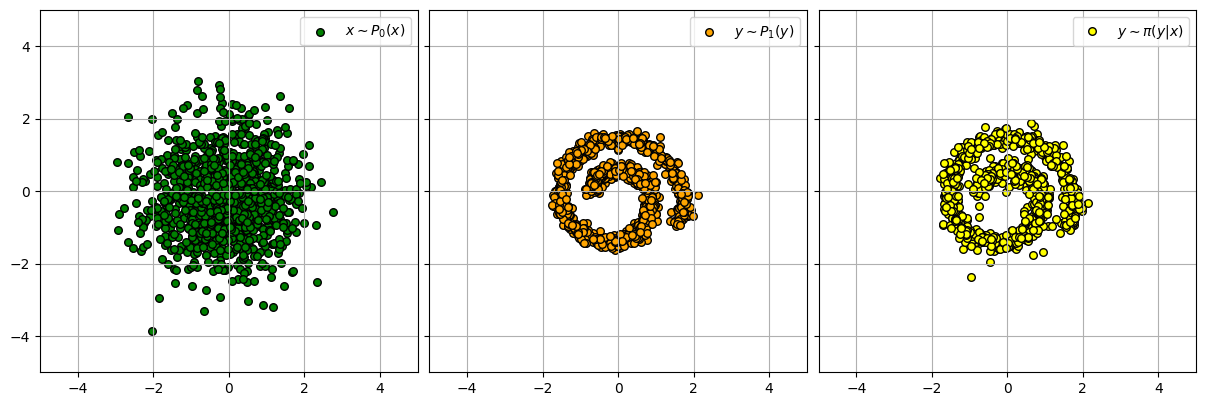

In [32]:

sample_batch_size = 1024

x_0_samples = sampler_x(sample_batch_size).to(device)

x_1_samples = sampler_y(sample_batch_size)

score_fn = model.get_score_fn(x_0_samples)

get_drift_fn_MCMC = lambda x_t, t: model.get_drift_MCMC(x_t, t, n_prime_samples=n_prime_samples,
                        n_double_prime_samples=n_double_prime_samples,
                        reinforce=False,
                        eta=eta, n_steps=n_steps)

get_drift_fn_MC =  lambda x_t, t: model.get_drift_MC(x_t, t, n_prime_samples=n_mc_samples)

if drift_estimation_method == 'MC': 
    x_1_pred = sample_sde(x_0_samples.to(device), get_drift_fn_MC, em_steps=sample_sde_em_steps)
else:
    
    x_proposal = sample_sde(x_0_samples.to(device), get_drift_fn_MCMC, em_steps=100)
    
    x_1_pred = langevin_sample(x_proposal, score_fn, eta=sampling_eta, n_steps=5000)
            
# x_1_pred = langevin_sample(x_1_red, score_fn, eta=sampling_eta, n_steps=5000)

pca_plot(x_0_samples.cpu(), x_1_samples.cpu(), x_1_pred.cpu(),
         n_plot=sample_batch_size, save_name=f'Swiss_Roll_HardSBM_{eps}.png', is_wandb=wandb.run)


In [ ]:

torch.save(model.state_dict(), f'hardsbm_swiss_roll_eps_{eps}_{drift_estimation_method}.pth')
